<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/labs/Lab_08b_Deutsch_Jozsa_and_Bernstein_Vazirani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [1]:
try:
  import qiskit
  print(f'Qiskit version: {qiskit.__version__}')
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:
  from qiskit_aer import QasmSimulator
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:
  from qiskit_ibm_runtime import QiskitRuntimeService
except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]


# !pip install --quiet graphviz
# !apt-get install graphviz

Qiskit version: 2.0.0


### Initialize

In [2]:
# %matplotlib inline

from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
from scipy import constants
import math
import time


#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# #QuTiP imports
# import qutip as qt
# from qutip import *
# #QUTIP QIP
# from qutip.qip import *
# from qutip_qip.circuit import QubitCircuit
# from qutip_qip.operations import Gate
# from qutip_qip.qasm import circuit_to_qasm_str


#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, array_to_latex
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector


#Qisket imports
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.ibmq import least_busy
# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator

# """Show ALL outputs, not just last expression"""
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Lab 8b - Phase Kickback Algorithms

Topics covered:
* Deutsch-Jozsa Algorithm
* Phase Kickback
* Bernstein-Vazirani Algorithm 
* Oracle query algorithms


# Deutsch-Jozsa Algorithm



Problem:

We want to know how a function 'f' will respond to almost all of its possible inputs without having to input them all into the function to check.


That is, a function f(x) will take a binary bit string 'x' and output a '0' or a '1' and we know that the function is of two possible types. Either:
1.  Constant - outputting 0 or 1 **regardless** of the input

***or ***

2.  Balanced - outputting '0' 50% of the time and '1' 50% of the time.

Our task is to figure out what type of function it is.
1. Does it always output 1? Does it always output 0? → Then it is constant.
1. Does it output 1 half of the time? (and 0 the other half?) → Then it is balanced.

---

**Classically** we would need to check HALF of the possible inputs (plus one more) as a worst case to know which is which! If all are the same then we know it is a constant function, but if any are different then it must be balanced.

Quantum Mechanically we only need to query **once**!!!

How!?!?!

Let's walk through an example.

References:
* Lecture by Deutsch - http://www.quiprocone.org/Protected/Lecture_5.htm
* https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html


## Constant Oracle
Start by creating a constant oracle by randomly setting the output qubit to be 0 or 1 (regardless of the input register).

Constant oracle output = 1


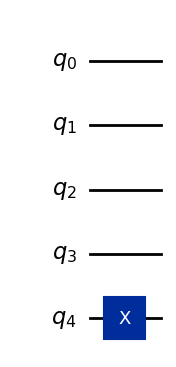

In [3]:
# Set the size of the input register
n = 4

'''
Constant Oracle
'''
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
    print("Constant oracle output = 1")
else:
    print("Constant oracle output = 0")

const_oracle.draw('mpl')

### Constant oracle is boring...
Note nothing really happens. Because the function doesn't care what the input is it just either randomly sets the output to be 0 or 1 using an X-gate...

We could input all of the possible permutations but it just will output the same state... Lame.

## Balanced Oracle

Now create a balanced oracle.

One way to create a balanced oracle is by performing CNOTs with each input qubit as a control and the output bit as the target.


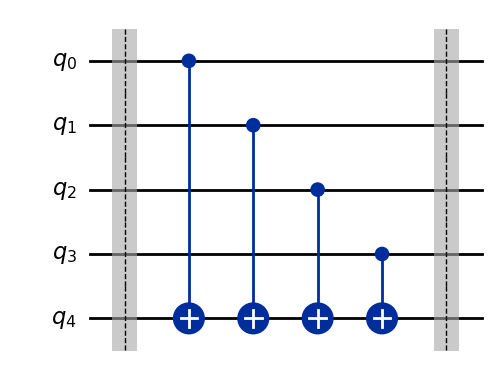

In [4]:
balanced_oracle = QuantumCircuit(n+1)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

balanced_oracle.draw('mpl')

Now that we have a balanced oracle we can vary the input states that give 0 or 1 by wrapping some of the control nots in X-gates. *This is just to mix it up a little.* The CNOTs are already dictating that the function is balanced, but this varies the outputs a little bit to make it more challenging classically to figure out.

For each qubit in our circuit, we place an X-gate if the corresponding digit in bstr is '1', or do nothing if the digit is '0'.

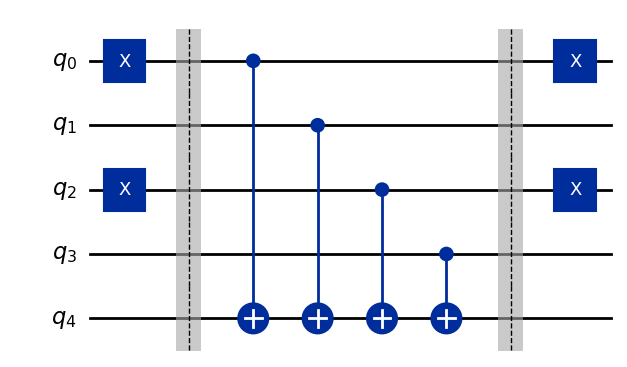

In [5]:

bstr = "101"

balanced_oracle = QuantumCircuit(n+1)

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider to make circuit easier to read.
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.name = "Balanced Oracle"

# Show oracle
balanced_oracle.draw('mpl')

Breaking down this circuit:

1. Flip some input states with X-gates to 'mix it up a little'
1. Apply controlled-NOT gates for the balanced oracle, using each input qubit as a control, and the output qubit as a target.
1. Undo the X-gates what we applied to 'mix it up' at the beginning.

(We don't want this balanced oracle to be as boring as the constant oracle do we?)

### Initializing the states

Now that the balanced oracle has been created, we need the Deutsch-Jozsa algorithm to solve it.

The first steps in the algorithm are to initialize the register:

1. Initialize the input qubits (0-3) in the state |+⟩ (with a H-gate)
1. Initialize the output qubit (4) in the state |−⟩ (with an X-gate then a H-gate)

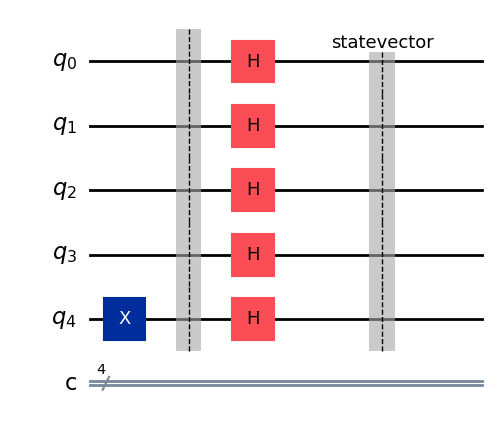

In [6]:
dj_circuit = QuantumCircuit(n+1, n)

'''
Initialize the output qubit in state |->
'''
dj_circuit.x(n)
dj_circuit.barrier() # Barrier just keeps H gates in a single column to look nice
dj_circuit.h(n)


'''
Initialize the input register qubits in state |+>
'''
for qubit in range(n):
    dj_circuit.h(qubit)


dj_circuit.save_statevector() #Measure Statevector

dj_circuit.draw('mpl')

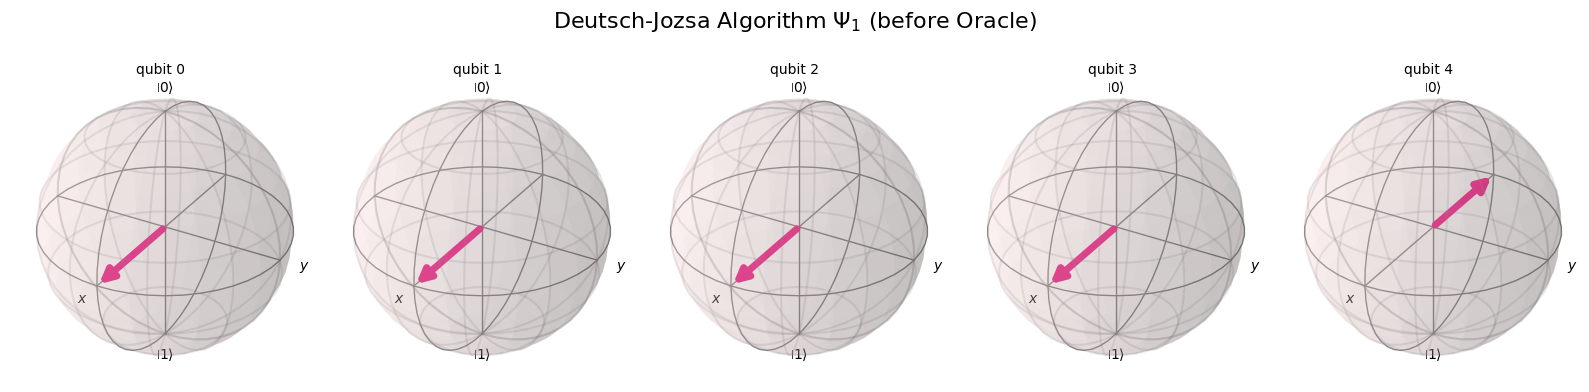

In [12]:
'''#Simulate'''

QasmSim = QasmSimulator() #Set simulator to evolve state

job_sim = QasmSim.run(dj_circuit, shots=1) #run one shot for statevector
result_sim = job_sim.result()

'''# Get the statevector from result'''
statevector = result_sim.get_statevector(dj_circuit)

# print(statevector)

# https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.draw.html#qiskit.quantum_info.Statevector.draw

# plot_state_city(statevector)
# statevector.draw('city')

figure = plot_bloch_multivector(statevector, title=r'Deutsch-Jozsa Algorithm $\Psi_1$ (before Oracle)')
ax = figure.get_axes()
display(figure)

Now apply the balanced_oracle function from earlier to apply the oracle

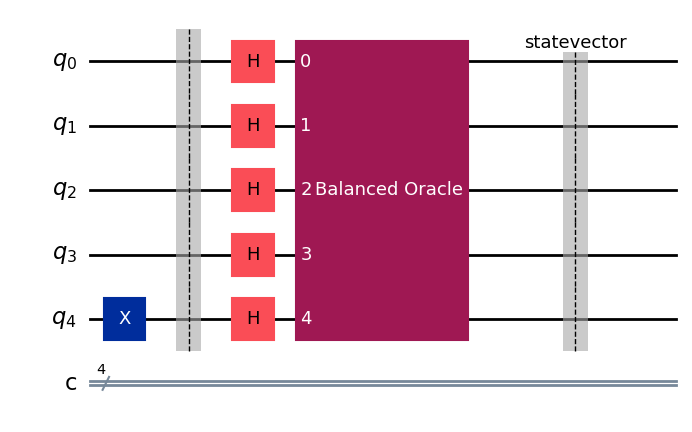

In [13]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit.append(balanced_oracle, range(n+1))

dj_circuit.save_statevector() #Measure Statevector

dj_circuit.draw('mpl')

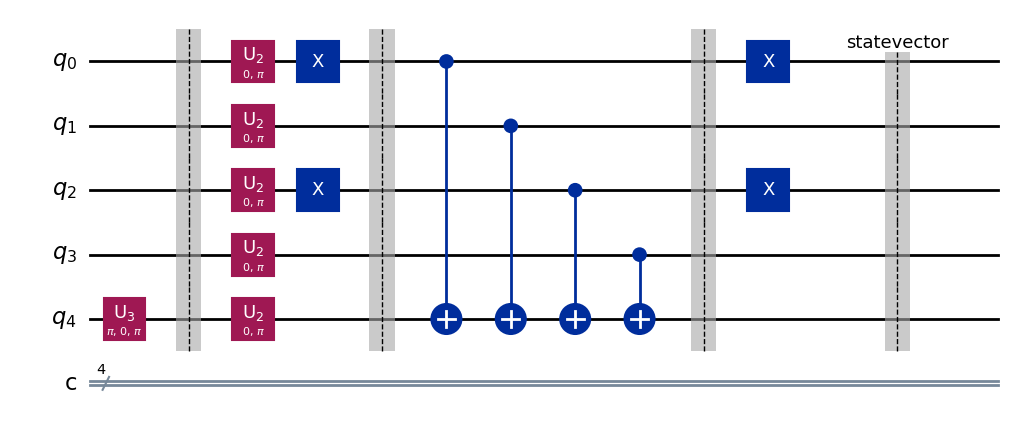

In [14]:
decomposed_circ = dj_circuit.decompose() # Decompose circuit (but don't modify)

decomposed_circ.draw('mpl')

In [15]:
'''#Simulate'''
job_sim = QasmSim.run(decomposed_circ, shots=1) #run one shot for statevector
result_sim = job_sim.result()

statevector_2 = result_sim.get_statevector(dj_circuit) #get statevector from result


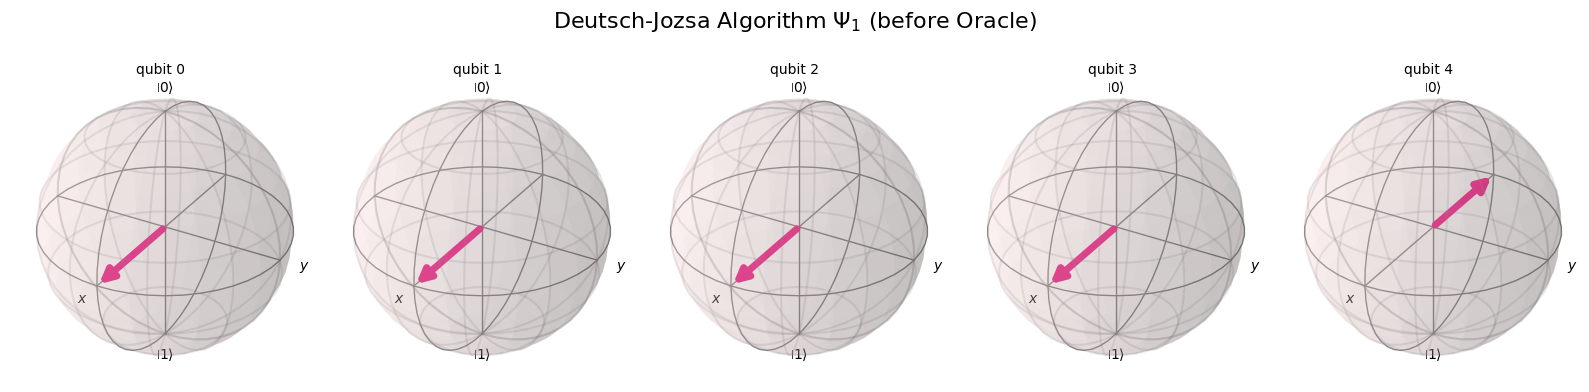

In [16]:
plot_bloch_multivector(statevector, title=r'Deutsch-Jozsa Algorithm $\Psi_1$ (before Oracle)')

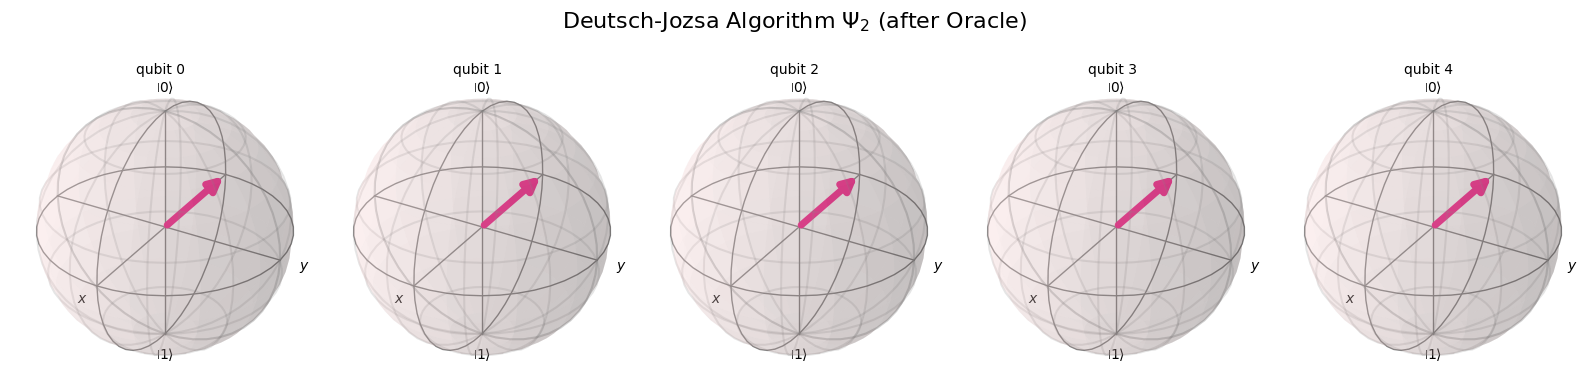

In [17]:
plot_bloch_multivector(statevector_2, title=r'Deutsch-Jozsa Algorithm $\Psi_2$ (after Oracle)')

# Phase Kickback

The output from the balanced oracle shows that each qubit in the input register has been flipped from |+⟩ to |-⟩ !

**This is due to "phase kickback".**

We typically think of CNOTs flipping the target bit only. However, when we have the input and output qubits in superpositions, the INPUT can get a phase flip depending on the output state. This 'reverse' operation is what allows us to query oracle in one step.

Finally, we perform H-gates on the n-input qubits to bring it back from the X basis (with information in phase) to the Z basis (information in the state, which we can measure).

And, last, measure the input register qubits:


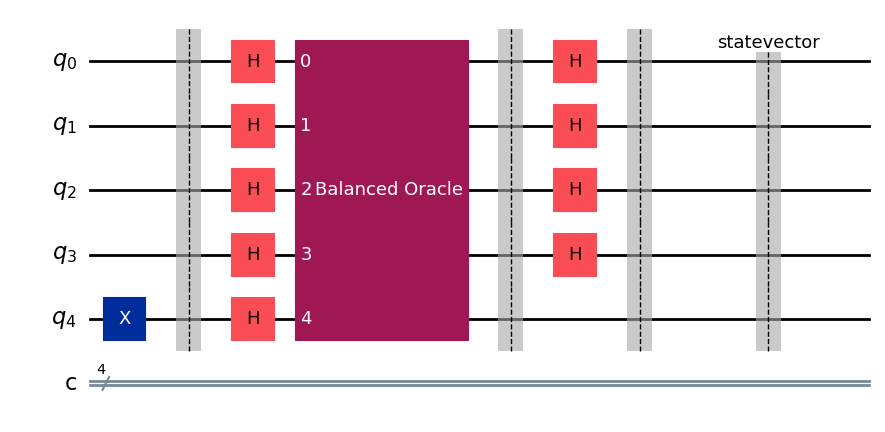

In [18]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)


# Add oracle
dj_circuit.append(balanced_oracle, range(n+1))

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# # Measure
# for i in range(n):
#     dj_circuit.measure(i, i)

dj_circuit.save_statevector() #Measure Statevector


# Display circuit
dj_circuit.draw('mpl')

In [19]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
decomposed_circ = dj_circuit.decompose() # Decompose circuit (but don't modify)
job_sim = QasmSim.run(decomposed_circ, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector_3 = result_sim.get_statevector(dj_circuit) # Get the statevector from result

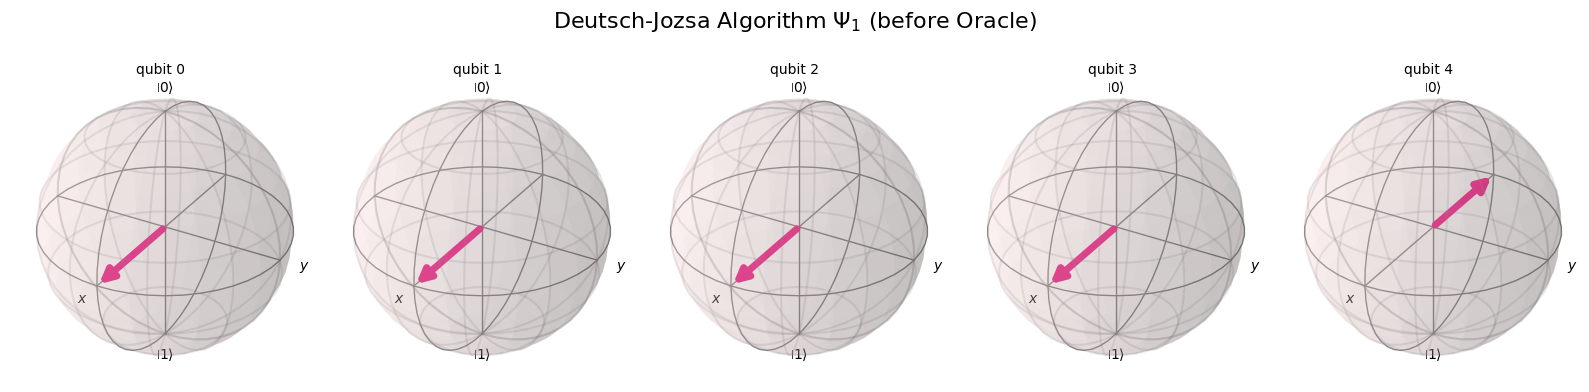

In [21]:
fig = plot_bloch_multivector(statevector, title=r'Deutsch-Jozsa Algorithm $\Psi_1$ (before Oracle)')
display(fig)
fig.savefig('animations/deutsch_jozsa/bloch_initial.png', bbox_inches='tight', pad_inches=0.1)

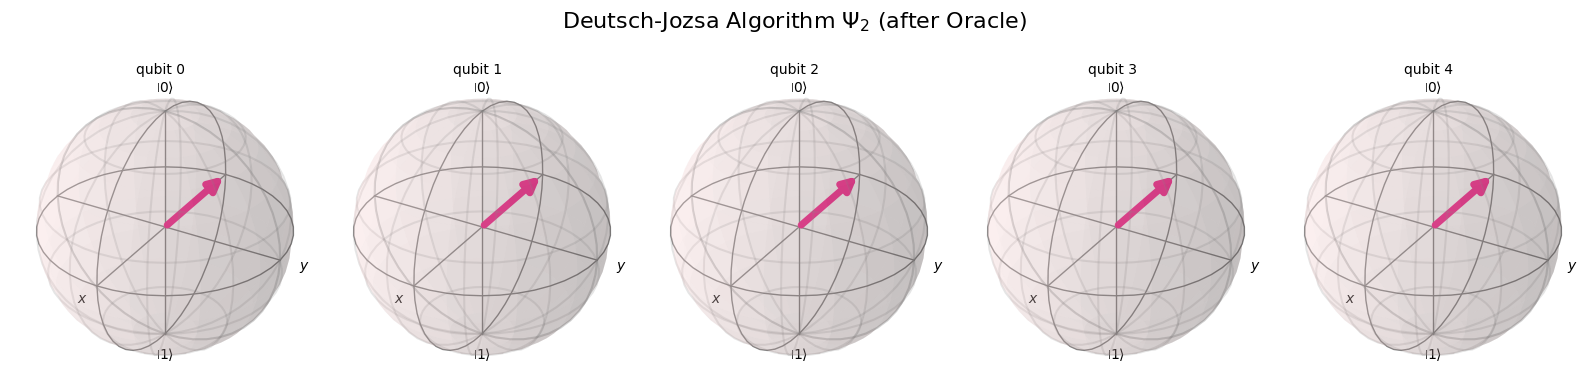

In [22]:
fig = plot_bloch_multivector(statevector_2, title=r'Deutsch-Jozsa Algorithm $\Psi_2$ (after Oracle)')
display(fig)
fig.savefig('animations/deutsch_jozsa/bloch_oracle.png', bbox_inches='tight', pad_inches=0.1)

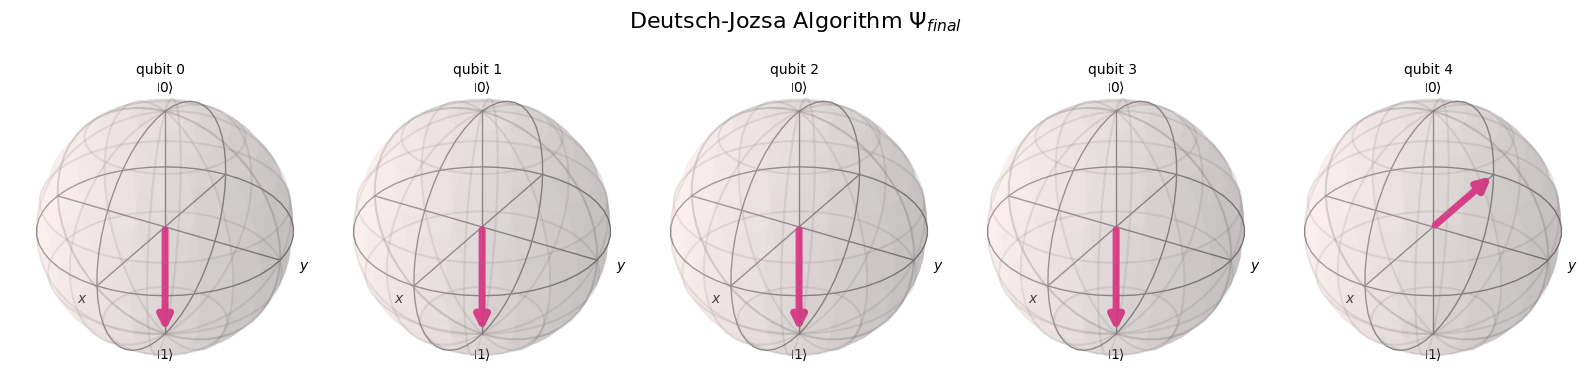

In [23]:
fig = plot_bloch_multivector(statevector_3, title=r'Deutsch-Jozsa Algorithm $\Psi_{final}$')
display(fig)
fig.savefig('animations/deutsch_jozsa/bloch_final.png', bbox_inches='tight', pad_inches=0.1)

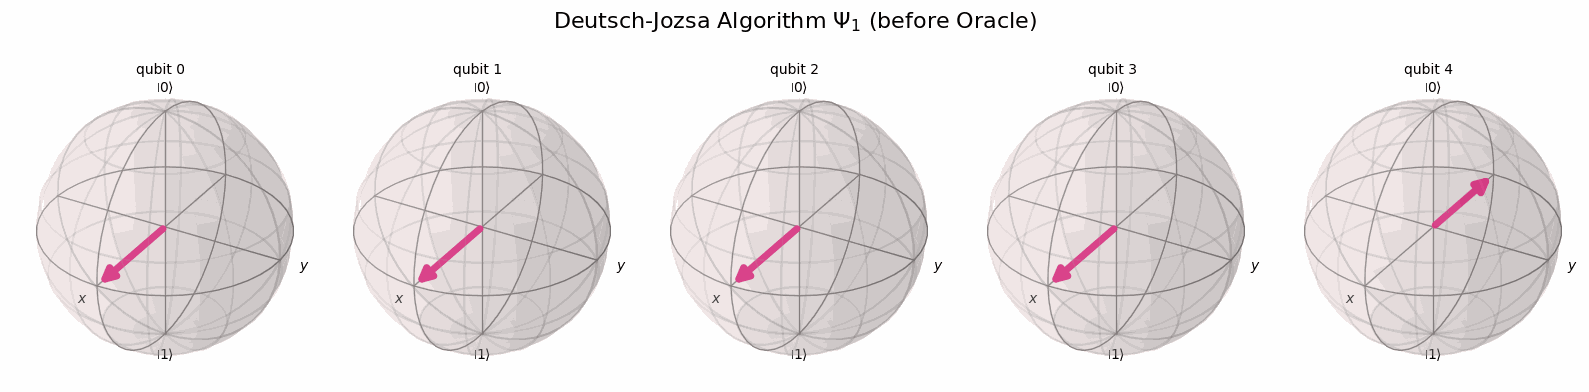

In [25]:
from PIL import Image
import glob

# Load the PNG files in order
image_files = ['animations/deutsch_jozsa/bloch_initial.png', 'animations/deutsch_jozsa/bloch_oracle.png', 'animations/deutsch_jozsa/bloch_final.png']
images = [Image.open(f) for f in image_files]

# Create and save GIF animation
images[0].save('animations/deutsch_jozsa_steps.gif',
               save_all=True,
               append_images=images[1:],
               duration=1500, # ms per frame
               loop=0)

# Display the animation
from IPython.display import Image
display(Image('animations/deutsch_jozsa_steps.gif'))


All of the input bits have been flipped from initially being in |0⟩ to |1⟩!

---

## Constant Oracle

Let us see what happens with the constant oracle

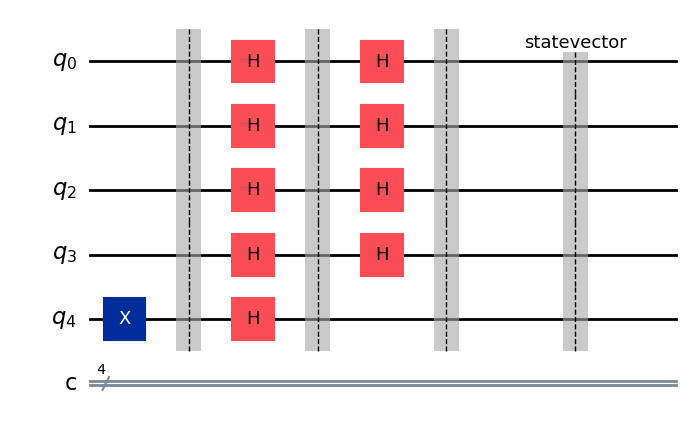

In [26]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Constant oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# # Measure
# for i in range(n):
#     dj_circuit.measure(i, i)

dj_circuit.save_statevector() #Measure Statevector

# Display circuit
dj_circuit.draw('mpl')

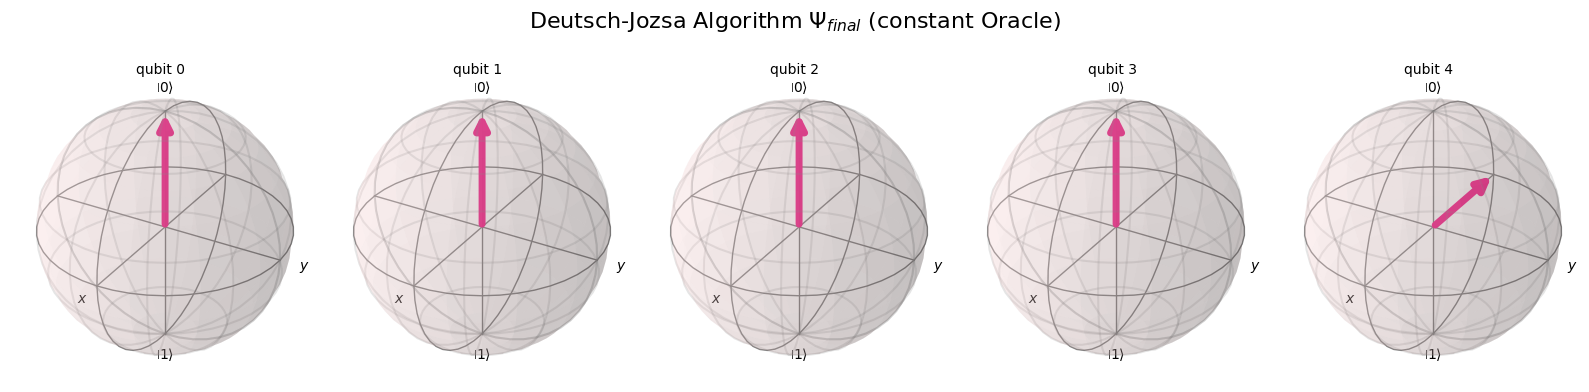

In [27]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(dj_circuit, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector_const = result_sim.get_statevector(dj_circuit) # Get the statevector from result

fig = plot_bloch_multivector(statevector_const, title=r'Deutsch-Jozsa Algorithm $\Psi_{final}$ (constant Oracle)')
display(fig)
# os.makedirs('animations/deutsch_jozsa', exist_ok=True)
# fig.savefig('animations/deutsch_jozsa/constant_oracle_final_state.png')
# plt.close(fig)

### No Phase kickback

A constant oracle doesn't have any phase kickback to the input register. So none of the input qubits are flipped. This means that it must be a constant that is independent of the inputs.


# Phase Kickback derivation

Recall first how we created an entangled state by applying a CNOT to a superposition state.

> Reference: https://qiskit.org/textbook/ch-gates/phase-kickback.html
https://github.com/Qiskit/textbook/blob/main/notebooks/ch-gates/phase-kickback.ipynb


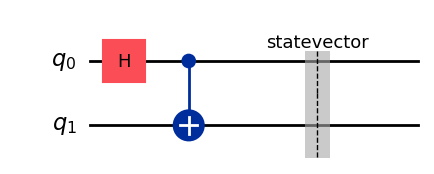

In [28]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.save_statevector() #Measure Statevector
qc.draw('mpl')

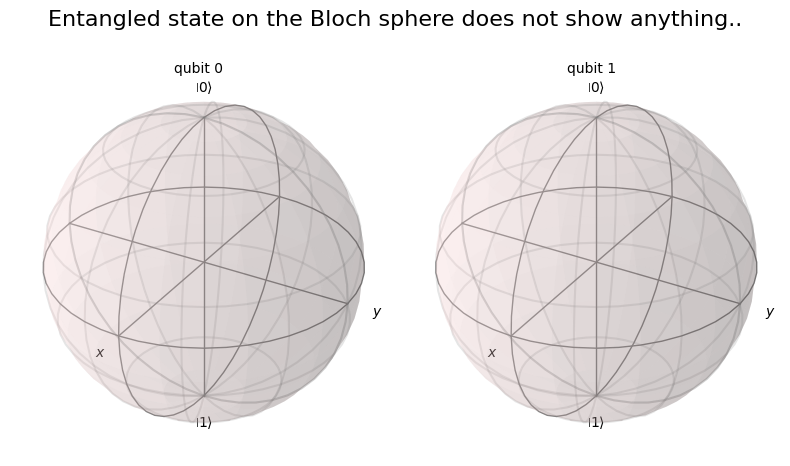

In [ ]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector = result_sim.get_statevector(qc) # Get the statevector from result

plot_bloch_multivector(statevector , title='Entangled state on the Bloch sphere does not show anything..', figsize=(4,4))

Having the control qubit 0 in a superposition caused the CNOT gate to create the Bell State:

$Ψ = \frac{1}{\sqrt{2}}(|00⟩ + |11⟩)$

If it is in 0 it doesn't flip qubit 1 but if it is in 1 it flips qubit 1.

This entangled state can not be decomposed/factored into single qubit states.

----

Now, let us also put the output state into a superposition before applying the CNOT gate and see what happens

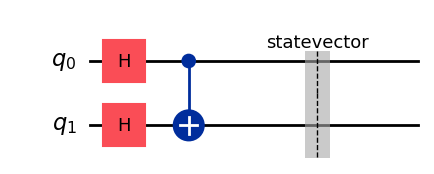

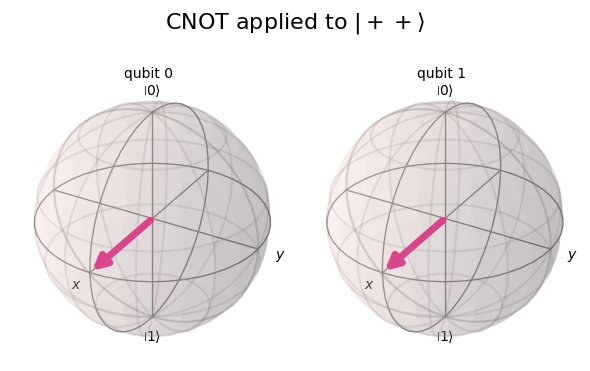

In [58]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.save_statevector() #Measure Statevector

display(qc.draw('mpl'))

'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector = result_sim.get_statevector(qc) # Get the statevector from result

fig = plot_bloch_multivector(statevector, title=r'CNOT applied to $|++\rangle$', figsize=(3,3)) #plot the statevector on the Bloch Sphere
display(fig)
fig.savefig('animations/deutsch_jozsa/phase_kickback_CNOTpp.png', bbox_inches='tight', pad_inches=0.1)

Now it seems like the CNOT gate doesn't have any effect!
We have the same state after the CNOT as we did before the CNOT.
Both qubits are in the superposition state |+⟩.

What if we flip the output qubit first so that it is in the |-⟩ state instead?

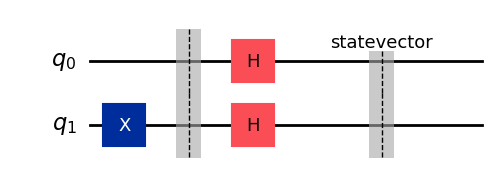

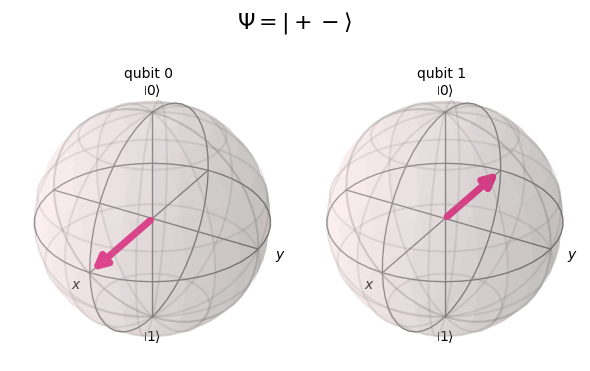

<IPython.core.display.Latex object>

Basis = |00>, |01>, |10> , |11> 


In [57]:
qc = QuantumCircuit(2)
qc.x(1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.save_statevector() #Measure Statevector

display(qc.draw('mpl'))

'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector = result_sim.get_statevector(qc) # Get the statevector from result

fig = plot_bloch_multivector(statevector,title=r'$\Psi=|+-\rangle$', figsize=(3,3)) #plot the statevector on the Bloch Sphere
display(fig)
fig.savefig('animations/deutsch_jozsa/phase_kickback_pm.png', bbox_inches='tight', pad_inches=0.1)

display(array_to_latex(statevector, prefix="\\text{Statevector} = "))
print("Basis = |00>, |01>, |10> , |11> ")

This creates the state:

 $|q_1 q_0⟩ = |-+⟩ = $

 $= \frac{1}{\sqrt{2}} [|0⟩-|1⟩] ⊗  \frac{1}{\sqrt{2}} [|0⟩+|1⟩] $

 $= \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]$


> NOTE: the odd 'backwards' notation that qubit 1 is the first qubit and qubit 0 is the last qubit.

----

Now we add the CNOT again to this state:

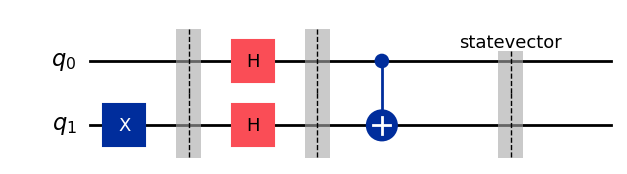

<IPython.core.display.Latex object>

Basis = |00>, |01>, |10> , |11> 
Before CNOT


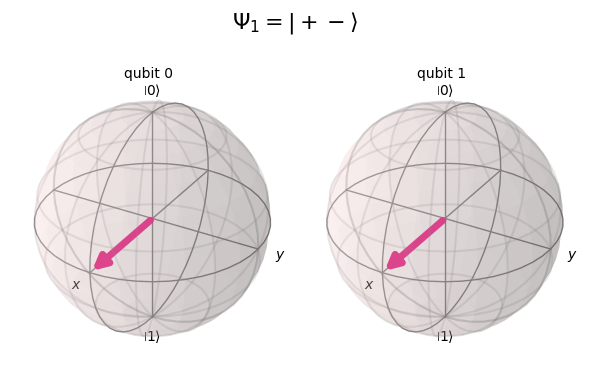

After CNOT


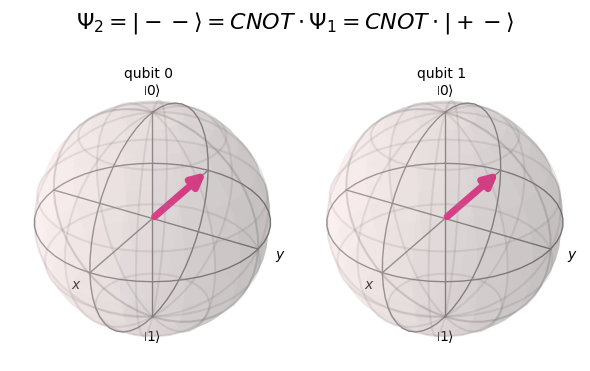

In [59]:
qc = QuantumCircuit(2)
qc.x(1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.barrier()
qc.cx(0,1)
qc.save_statevector() #Measure Statevector

display(qc.draw('mpl'))

'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
result_sim = job_sim.result()
statevector2 = result_sim.get_statevector(qc) # Get the statevector from result

display(array_to_latex(statevector2, prefix="\\text{Statevector} = "))
print("Basis = |00>, |01>, |10> , |11> ")

print('Before CNOT')
display(plot_bloch_multivector(statevector,title=r'$\Psi_1=|+-\rangle$', figsize=(3,3))) #plot the statevector on the Bloch Sphere

print('After CNOT')
fig = plot_bloch_multivector(statevector2,title=r'$\Psi_2=|--\rangle=CNOT\cdot\Psi_1=CNOT\cdot|+-\rangle$', figsize=(3,3)) #plot the statevector on the Bloch Sphere
display(fig)
fig.savefig('animations/deutsch_jozsa/phase_kickback_CNOTpm.png', bbox_inches='tight', pad_inches=0.1)



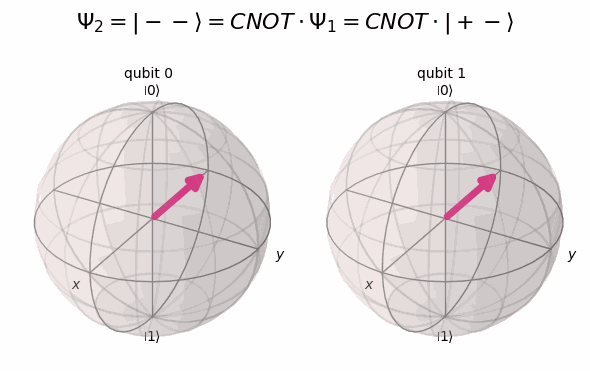

In [62]:
from PIL import Image
import glob

image_files = ['animations/deutsch_jozsa/phase_kickback_CNOTpm.png', 'animations/deutsch_jozsa/phase_kickback_pm.png']
images = [Image.open(f) for f in image_files]

images[0].save('animations/phase_kickback.gif',save_all=True,append_images=images[1:],duration=2000,loop=0)

from IPython.display import Image
display(Image('animations/phase_kickback.gif'))


The CNOT acting on the state ($q_0$=control, $q_1$=target):

$ |q_1 q_0⟩ = |-+⟩ = \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]$

* CNOT Flips the $q_1$ in the state $|q_1 q_0⟩ =|01⟩$ to $|q_1 q_0⟩ =|11⟩$

* and conversely also flips the $q_1$ in $|q_1 q_0⟩ =|11⟩$ state to $|q_1 q_0⟩ =|01⟩$

> Again note the odd 'backwards' notation that the control qubit 0 is the last qubit and the target qubit 1 is the first qubit.

This SWAPs their amplitudes and since we had prepared them with different signs they flip **sign**.

Together:

$CNOT|-+⟩ = |q_1 q_0⟩ = $

$ = CNOT \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]  $

$=\frac{1}{2}[|00⟩ - |01⟩ - |10⟩ + |11⟩]$

$= \frac{1}{\sqrt{2}} [|0⟩-|1⟩] ⊗  \frac{1}{\sqrt{2}} [|0⟩-|1⟩] $

$= |--⟩$

So we get the somewhat surprising result that:

## $CNOT|-+⟩ = |--⟩$

We use this effect of phase kickback for these phase oracles by putting the input states into a superposition state of |+⟩ and the output state into the superposition state |-⟩ and see if the input states get phase kickbacks during the application of the oracle.

One way to interpret why these algorithms work is to see that they flip the input and output of the classical function. Because the output is modulo 2 it can only give information one bit at a time. By using phase kickback to make the input an output of the circuit we get a bit of information from every input bit (which is all of it). Indeed we don't even need to measure the 'output' bit!!!

# Simulate the DJ algorithm
What is the output when we have a balanced oracle?

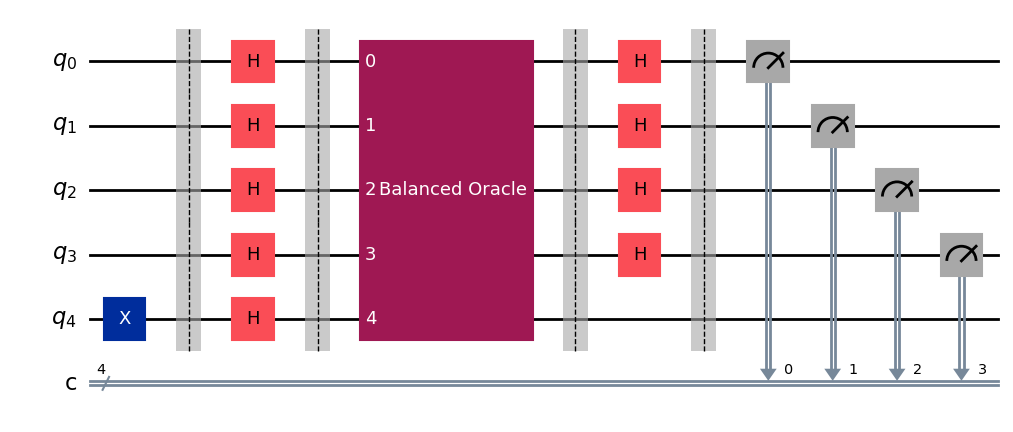

In [63]:

dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

dj_circuit.barrier()

'''
Add the Balanced Oracle
'''
dj_circuit.append(balanced_oracle, range(n+1))

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')


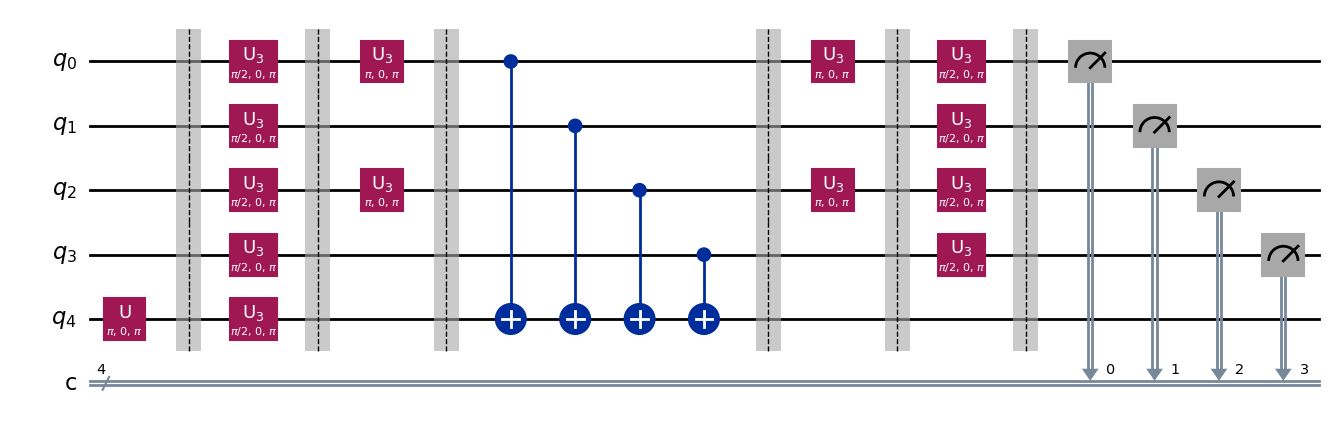

In [64]:
decomposed_circ = dj_circuit.decompose() # Decompose circuit (but don't modify)
decomposed_circ2 = decomposed_circ.decompose() # Decompose circuit (but don't modify)
decomposed_circ2.draw('mpl')

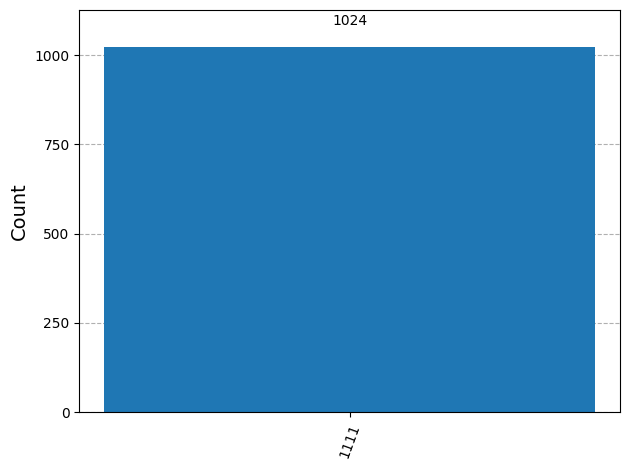

In [65]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
n_shots = 1024
decomposed_circ = dj_circuit.decompose() # Decompose circuit (but don't modify)
job_sim = QasmSim.run(decomposed_circ, shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts()

# Plot results
plot_histogram(counts)

If the state is not all 0's  |0 0 0 0⟩ that means the function is balanced.

We can see from the results above that we have a 0% chance of measuring 0000 (or any other state than |1111⟩ for that matter).

This correctly predicts the function is balanced.

# Run on fake IBM hardware

In [66]:
# Check if token needs to be set
token = "INSERT YOUR TOKEN HERE"

if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [67]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [68]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

In [69]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

service = QiskitRuntimeService()

backend = FakeBrisbane()
backend.refresh(service)

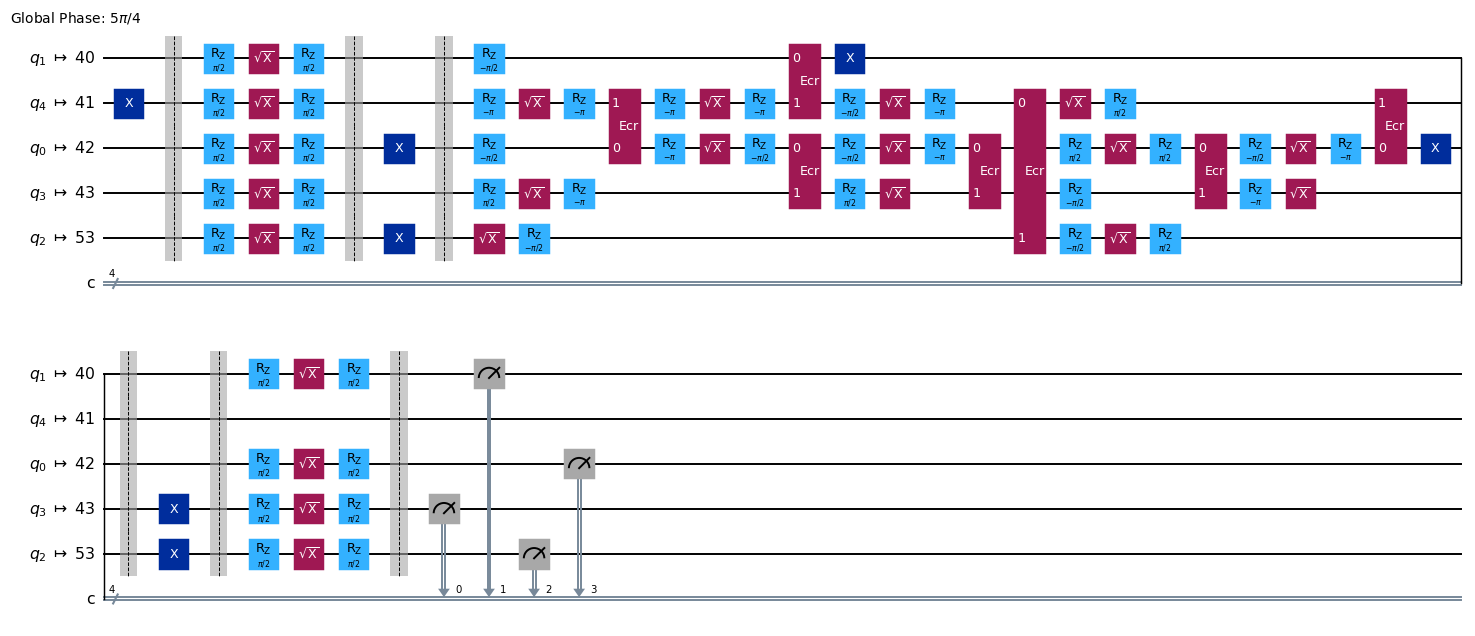

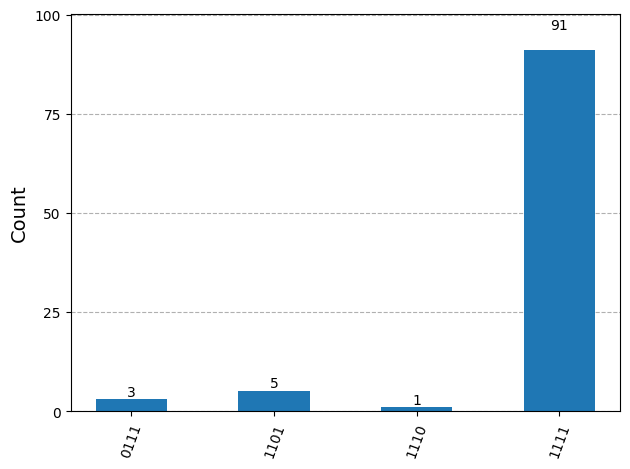

In [70]:
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(decomposed_circ, backend)
display(transpiled_circuit.draw('mpl', style="iqp",idle_wires=False ,scale=0.7, fold=30))

# Run the transpiled circuit using the simulated fake backend
job = backend.run(transpiled_circuit, shots = 100)
counts = job.result().get_counts()
plot_histogram(counts)

In [71]:
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)

Most frequent measured bit string =  1111


In [73]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


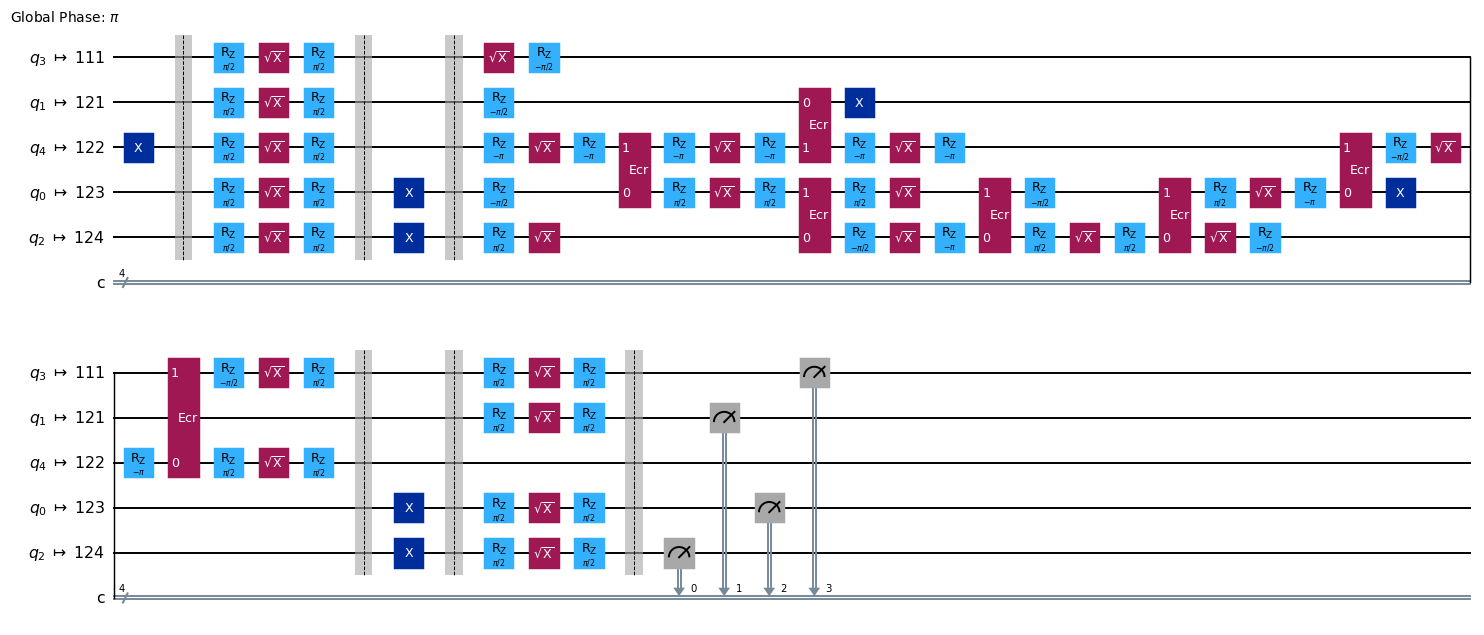

In [74]:
transpiled_circuit = transpile(decomposed_circ, backend)
display(transpiled_circuit.draw('mpl', style="iqp",idle_wires=False ,scale=0.7, fold=30))

In [80]:
sampler = Sampler(mode=backend)
 
job = sampler.run([transpiled_circuit], shots=1000)
counts = job.result()[0].data.c.get_counts()

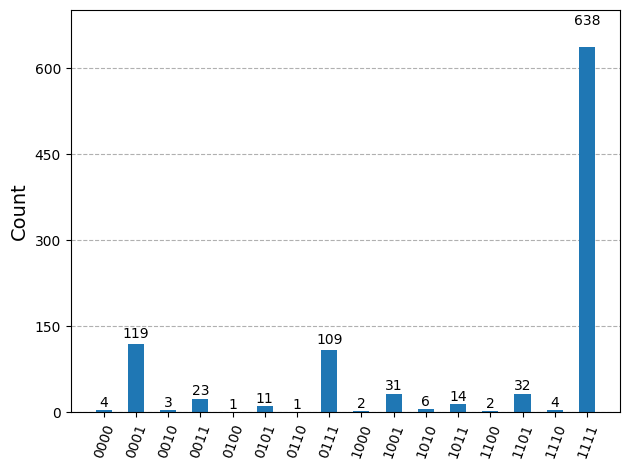

Most frequent measured bit string =  1111


In [81]:
display(plot_histogram(counts))

# Find the most frequent string by getting max count
answer = max(counts.items(), key=lambda x: x[1])[0]

print( 'Most frequent measured bit string = ' , answer)

We get a small chance that the state is |0000⟩ but only about 1%. This is due to errors during the circuit. Repeating the circuit many times we see we get other results ~98% of the time indicating the oracle is balanced.

# Run the Constant Oracle on fake hardware

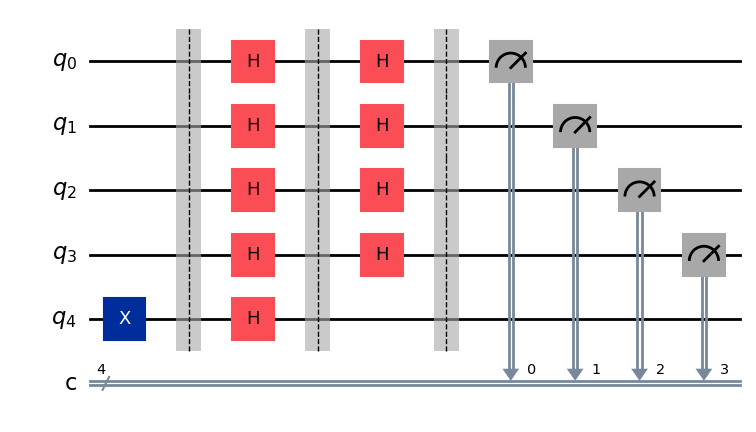

In [82]:

dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

'''
Add the Constant Oracle
'''
#nothing...

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

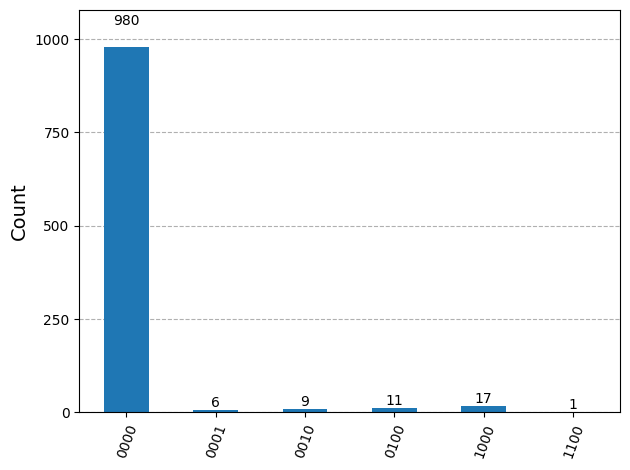

In [83]:
backend = FakeBrisbane()

transpiled_circuit = transpile(dj_circuit, backend)
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

In [84]:
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)

Most frequent measured bit string =  0000


0000! Success! It is constant oracle with no phase kick back to any of the inputs.

# Bernstein-Vazirani Algorithm

(aka, Secret Dot Product String)

Deutsch’s algorithm and the Deutsch-Jozsa algorithm both followed the same steps:
1. Apply Hadamard gates
1. Query the Oracle
1. Apply Hadamard gates again
1. Measure

Since this worked so well, are there any other problems that can be solved
by this procedure? The answer is yes. There is another problem that a quantum computer can solve using this procedure.


It is finding a **secret n-bit string** by querying an oracle which takes the dot product of the string with the input.


>That is, we again have a function 'f' that outputs 0 or 1 and can accept a long bit string 'x' as input. But now the promise is that f(x) = s·x, where 's' is an unknown string.

## How do we figure out what the secret string 's' is?

Classically, we would have to query the function with permutations of a 1 on each input.

\begin{align}
f(0001) = s_3 (0)+s_2 (0)+s_1 (0)+s_0 (1) = s_0 \\
f(0010) = s_3 (0)+s_2 (0)+s_1 (1)+s_0 (0) = s_1 \\
f(0100) = s_3 (0)+s_2 (1)+s_1 (0)+s_0 (0) = s_2 \\
f(1000) = s_3 (1)+s_2 (0)+s_1 (0)+s_0 (0) = s_3
\end{align}

Requiring n queries.

Quantum mechanically we only need one.

Let's try it.


Reference:

* [Bernstein-Varizani Algorithm, Qiskit](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html)
* Thomas Wong's book - 7.4 'Secret Dot Product String'

## Create the 'Secret' bit string 's'
Set the number qubits needed to represent s



In [86]:
s = '1011001'

#number of qubits required to encode s
n = len(s)
print(n)

7


Apply Hadamard gates to the qubits, apply an additional Z-gate to the auxiliary qubit

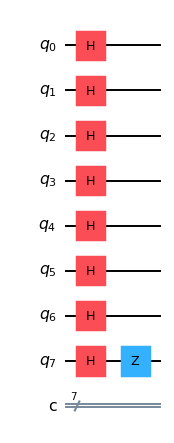

In [90]:
# n qubits to encode 's' , plus one auxillary qubit
bv_circuit = QuantumCircuit(n+1, n)


# Initialize the auxiliary qubit to state |->
bv_circuit.h(n)
bv_circuit.z(n)

# bv_circuit.barrier()

# Apply Hadamard gates to the input register before querying the oracle
for i in range(n):
    bv_circuit.h(i)

bv_circuit.draw('mpl',scale = 0.7)

Note: we can prepare the |-⟩ state of the 'output' qubit_4 multiple ways.

Here we create the |+⟩ state first with a Hadamard, then apply a Z-gate, rotating the phase to the |-⟩ state.

Next query the inner-product oracle:

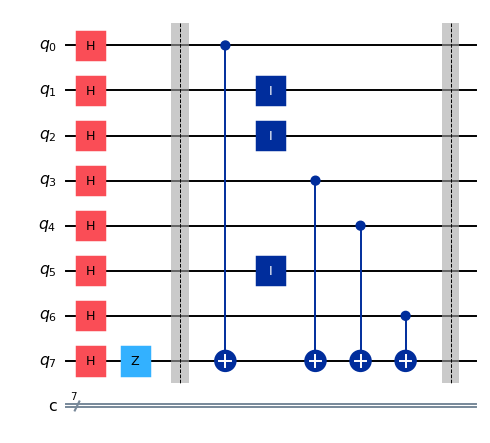

In [91]:
bv_circuit.barrier()

'''
Oracle for secret 's' string
'''
s_rev = s[::-1] # reverse s to fit qiskit's qubit ordering

for q in range(n):
    if s_rev[q] == '0':
        #If zero just pass the qubit through
        bv_circuit.id(q)
    else:
        #If 1 then
        bv_circuit.cx(q, n)

bv_circuit.barrier()

bv_circuit.draw('mpl',scale = 0.7)

Apply Hadamard gates after querying

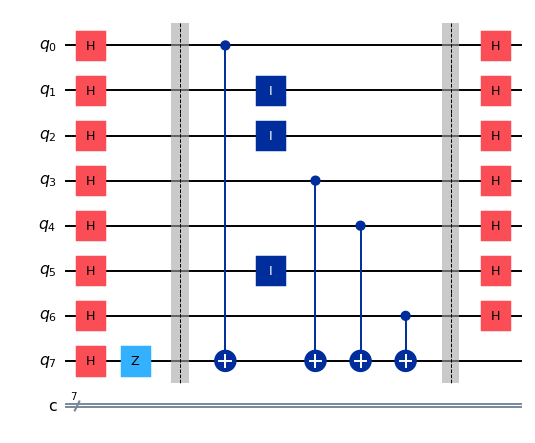

In [92]:
#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

bv_circuit.draw('mpl',scale = 0.7)

We complete the circuit by measuring the outputs and storing them onto classical bits:

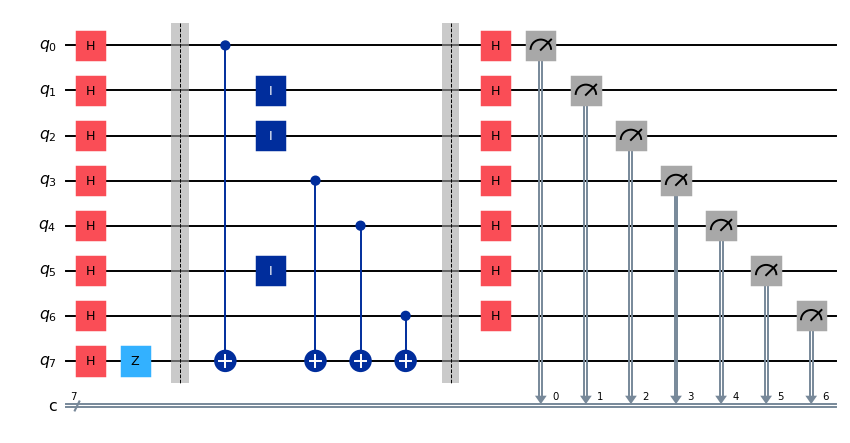

In [93]:
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl',scale = 0.7)

Simulate the quantum circuit:

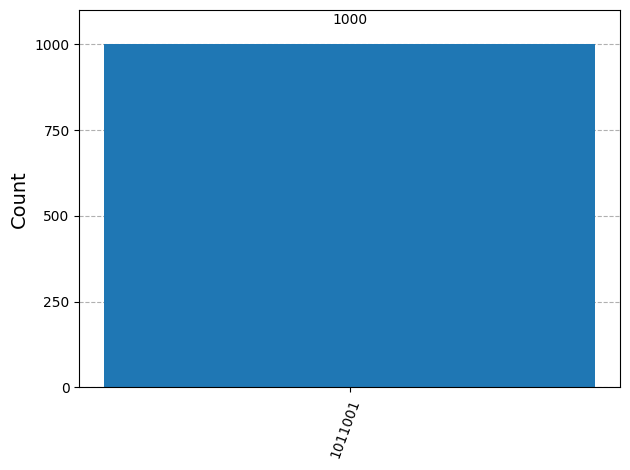

In [94]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(bv_circuit, shots=1000)
result_sim = job_sim.result()
counts = result_sim.get_counts()

# Plot results
plot_histogram(counts)

In [95]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()

print( 'Most frequent measured bit string = ' , answer)

#What was the desired solution again?
print( 'Secret s string  = ' , s)

Most frequent measured bit string =  1011001
Secret s string  =  1011001


## Run on fake IBM Hardware

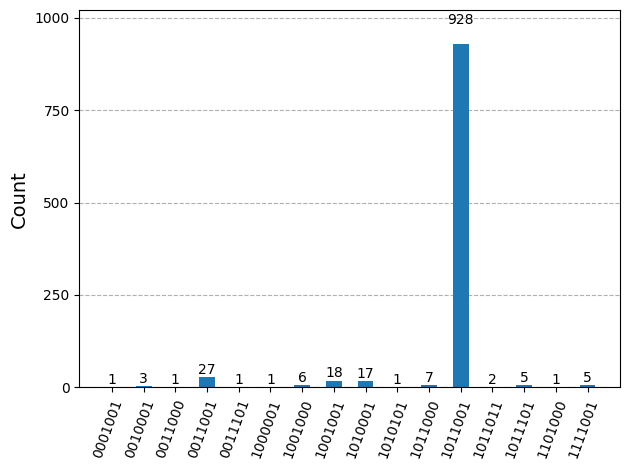

In [96]:
backend = FakeBrisbane()

transpiled_circuit = transpile(bv_circuit, backend)

job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

In [97]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()

print( 'Most frequent measured bit string = ' , answer)

#What was the desired solution again?
print( 'Secret s string  = ' , s)


Most frequent measured bit string =  1011001
Secret s string  =  1011001


Not bad! Most of the shots give the correct secret string.

## Further reading:

### Simon's Algorithm (https://qiskit.org/textbook/ch-algorithms/simon.html)


# Homework 8  
> (due 4/7/2025 at noon)

1. Use the same notebook as for the qubit benchmarking lab
    (just add these two problems)
1. Work with a partner or group of three to solve the problems
1. Summarize your results in a short report and upload to gradescope
1. Include a link to your colab notebook code 
1. Make sure the link gives 'General access' for 'Anyone with the link' to comment (and view)



# Exercises


  1. Setup a Phase kickback circuit and verify the states of both qubits (and the statevector) at each step after each gate.

  1. Show how phase kickback allows the 'flip' of the control qubit and the target qubit of a CNOT gate such that if a Transmon circuit only has one way coupling between neighboring qubits, the CNOT can STILL operate in both directions.


In [ ]:
'''
Exercise 1
'''


In [ ]:
'''
Exercise 2
'''
